In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np

from network import Population, RateNetwork
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt 

logging.basicConfig(level=logging.INFO)

### Initial Parameters

In [3]:
### Transfer function
phi_mu = 0
phi_sigma = 0.2

### Cortex 
N_ctx = 10000
S_ctx, P_ctx = 1, 10

### BG 
N_bg = 10000
S_bg, P_bg = 1, 10

### Network
sparsity_cc, sparsity_bc, sparsity_bb, sparsity_cb = 0.05, 0.05, 0.05, 0.05
A_cc, A_bc, A_bb, A_cb = 10, 3, 0, 3

### Build Network

In [4]:
### Transfer function
phi = ErrorFunction(mu=phi_mu, sigma=phi_sigma).phi

In [5]:
### Cortical network
ctx = Population(N=N_ctx, tau=1e-2, phi=phi, name="ctx")
sequences_ctx = [GaussianSequence(P_ctx, ctx.size, seed=i) for i in range(S_ctx)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])

### BG network
bg = Population(N=N_bg, tau=1e-2, phi=phi, name="bg")
sequences_bg = [GaussianSequence(P_bg, bg.size, seed=i+1) for i in range(S_bg)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

In [6]:
### J_cc: attractors
J_cc = SparseConnectivity(source=ctx, target=ctx, p=sparsity_cc)
plasticity = ThresholdPlasticityRule(x_f=0, q_f=0.5)
synapse_cc = LinearSynapse(J_cc.K, A=A_cc)
J_cc.store_attractors(patterns_ctx[0], synapse_cc.h_EE, plasticity.f, plasticity.g)

### J_bc: sequences 
J_bc = SparseConnectivity(source=ctx, target=bg, p=sparsity_bc)
synapse_bc = LinearSynapse(J_bc.K, A=A_bc)
J_bc.store_sequences([patterns_bg, patterns_ctx], synapse_bc.h_EE, seq=True)

### J_bb: attractors
J_bb = SparseConnectivity(source=bg, target=bg, p=sparsity_bb)
plasticity = ThresholdPlasticityRule(x_f=0, q_f=0.5)
synapse_bb = LinearSynapse(J_bb.K, A=A_bb)
J_bb.store_attractors(patterns_bg[0], synapse_bb.h_EE, plasticity.f, plasticity.g)

### J_cb: sequences 
J_cb = SparseConnectivity(source=bg, target=ctx, p=sparsity_cb)
synapse_cb = LinearSynapse(J_cb.K, A=A_cb)
J_cb.store_sequences([patterns_ctx, patterns_bg], synapse_cb.h_EE, seq=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|██████████| 10000/10000 [00:01<00:00, 6955.38it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|██████████| 10000/10000 [00:01<00:00, 6771.18it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing sequences
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [7]:
### J_cc2: sequences 
J_cc2 = SparseConnectivity(source=ctx, target=ctx, p=sparsity_cc)
synapse_cc2 = LinearSynapse(J_bc.K, A=A_bc)
J_cc2.store_sequences([patterns_ctx, patterns_ctx], synapse_cc2.h_EE, seq=True)


INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing sequences
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


### Simulation 

In [8]:
### Initial input for simulation

init_input_ctx = patterns_ctx[0, 0, :]
init_input_bg = patterns_bg[0, 0, :]

In [9]:
from tqdm import tqdm, trange
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_EI=J_cb, formulation=1)
net_bg = RateNetwork(bg, c_EE=J_bb, c_EI=J_bc, formulation=1)
T=1
dt = 1e-3

fun_ctx = net_ctx._fun(T)
fun_bg = net_bg._fun(T)

r0 = ctx.phi(init_input_ctx)
r1 = bg.phi(init_input_bg)
t = np.arange(0, T, dt)

state_ctx = np.zeros((len(t)+1, N_ctx))
state_bg = np.zeros((len(t)+1, N_bg))
for i in trange(len(t)):
    r0 += fun_ctx(T, r0, r1)*dt
    r1 += fun_bg(T, r1, r0)*dt
    state_ctx[i] = r0
    state_bg[i] = r1

100%|██████████| 1000/1000 [00:43<00:00, 22.91it/s]


In [10]:
from scipy import stats

### Finds correlation between all patterns and rates over time 

def find_corr(state, phi_patterns):
    corr = []
    for p in phi_patterns[0]:
        corr.append([stats.pearsonr(state[i], p)[0] for i in range(int(T/dt))])
    return corr

In [11]:
phi_patterns_ctx = phi(patterns_ctx)
corr_ctx = find_corr(state_ctx, phi_patterns_ctx)

phi_patterns_bg = phi(patterns_bg)
corr_bg = find_corr(state_bg, phi_patterns_bg)

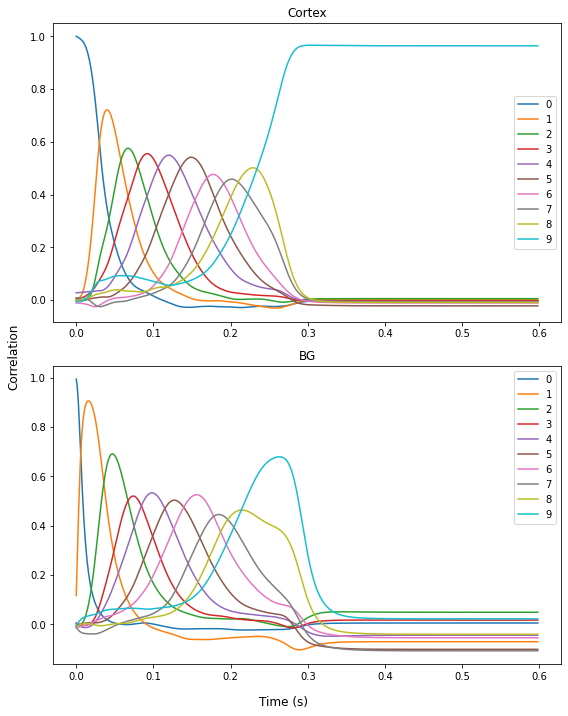

In [12]:
lim = 600
fig, axes = plt.subplots(2, figsize=[8,10])

lim = lim - T
for i, v in enumerate(corr_ctx):
    axes[0].plot(t[:lim], v[:lim], label=str(i))
    axes[0].legend()
    axes[0].set_title("Cortex")

for i, v in enumerate(corr_bg):
    axes[1].plot(t[:lim], v[:lim], label=str(i))
    axes[1].legend()
    axes[1].set_title("BG")
fig.supxlabel('Time (s)')
fig.supylabel('Correlation')
fig.tight_layout()
plt.savefig("../../output/ctx-r.jpg", bbox_inches='tight', dpi=300)

In [13]:
from scipy.signal import find_peaks

def maximize(A, values):
    maximum = -float('inf')
    ind = -1
    for i in A:
        if values[i] > maximum:
            maximum = values[i]
            ind = i
    return maximum, ind

def overlap(corr, patterns):
    peaks_index = [0]
    peaks = [1]
    for i in range(len(patterns)):
        if i == 0:
            continue
        else:
            try:
                ind = find_peaks(corr[i], height=0.3)[0][0]
                val = corr[i][ind]
                peaks_index.append(ind)
                peaks.append(val)
            except:
                continue
    return peaks, peaks_index

In [14]:
peaks_ctx, peaks_ind_ctx = overlap(corr_ctx, patterns_ctx[0])
peaks_bg, peaks_ind_bg = overlap(corr_bg, patterns_bg[0])

In [15]:
print(peaks_ctx)
print(np.mean(peaks_ctx))
print(np.mean(peaks_bg))

[1, 0.7212330710681731, 0.5754895604487202, 0.5548772557762286, 0.5490667138297225, 0.541234697552828, 0.4762324682732314, 0.4581843452233002, 0.501473053936891, 0.9660026363904803]
0.6343793802499575
0.626534578625044


In [16]:
peak_intervals_ctx = [peaks_ind_ctx[i+1]-peaks_ind_ctx[i] for i in range(len(peaks_ind_ctx)-1)]
peak_intervals_bg = [peaks_ind_bg[i+1]-peaks_ind_bg[i] for i in range(len(peaks_ind_bg)-1)]
print(np.mean(peak_intervals_ctx))
print(np.mean(peak_intervals_bg))

33.77777777777778
29.22222222222222
